# Finite Elements Method - Implementation

### The problem

Find $u \in V_h \subset V$ s.t. 
$$a(u,v) = \int_\Omega fv \qquad \forall v \in V_h$$

We consider a basis $\{v_i\}_{i=0}^{N-1}$ of $V_h$, then we are able to write each $v \in V_h$ as $v = \sum_i \alpha_i v_i$. 

Since $a(u,v) = \int_\Omega u'v'$, replacing $u,v$ we obtain 
$$a(u,v) = \sum_i \sum_j \alpha_i \beta_j a(v_i, v_j)$$
with
$u = \sum_i \alpha_i v_i, v = \sum_j \beta_j v_j$

Obtaining the matrix $A_{ij} = a(v_i, v_j)$ would then allow us to compute easily $a(u,v) \forall v \in V_h$. For the same reason, defining $f_i := \int_\Omega f v_i$ we get that
$$\int_\Omega fv = \sum_i \gamma_i \int_\Omega f_i \qquad v = \sum_j \beta_j v_j$$

Therefore, given a basis we would like to compute
$$f_i := \int_\Omega f v_i$$
and 
$$A_{ij} := \int_\Omega v_i' v_j'$$
Our domain $\Omega$ is a segment $[a,b]$ since we consider the 1D case. We split the segment in M segments (M+1 vertices). 

### The mapping trick

We want to subdivide the domain $\Omega$ in such a way that each sub-domain $T_k$ is obtainable via an affine mapping from a reference sub-domain $\hat{T}$. That is, $\forall k T_k = F_k(\hat{T})$. This is going to add some overhead since the derivatives becomes somehow more cluttered, but this has the invaluable computational advantage that many quantities are computed only once for the entire domain $\Omega$.

We denote the number of elements in which $\Omega$ is subdivided with $M$.

$$\begin{align}
\int_\Omega g &= \sum_{k=0}^{M-1} \int_{T_k} g\\
&= \sum_{k=0}^{M-1} \int_{\hat{T}} (g \circ F_k) J_k
\end{align}$$

with $J_k = \det \frac{\partial F_k}{\partial \hat{x}}$. We can now complete the integration using a quadrature formula having the form:
$$\int f = \sum_j f(x_j) w_j$$

The complete formula, using $N_q$ quadrature points with weights $w_j$, is then:
$$\int_\Omega g = \sum_{k=0}^{M-1} \sum_{j=0}^{N_q-1} (g \circ F_k)(\hat{x}) w_j J_k$$

### Renumbering and other differential amenities

We define a matrix 
$$P_{ki\alpha} = \begin{cases} 1 &v_i(F_k(\hat{x})) = \hat{V}_\alpha(\hat{x}) \qquad \forall \hat{x} \in \hat{T}\\
0 &\text{otherwise}\end{cases}$$

That is, a way to connect basis functions of $T_k$ and those of $\hat{T}$ which are in "some sense" compatible. This is allowed because we expect basis of $T_k$ to be derived (in some way) from those of $\hat{T}$.

In this way we can develop on the following integral:
$$\begin{align}
f_i = \int_\Omega f v_i &= \sum_k \int_{T_k} f v_i\\
&= \sum_k \int_{\hat{T}} ((f v_i) \circ F_k) (\hat{x}) J_k d\hat{x}\\
&= \sum_k \int_{\hat{T}} (f \circ F_k)(\hat{x}) (v_i \circ F_k)(\hat{x}) J_k d\hat{x}\\
&= \sum_\alpha \sum_k \int_{\hat{T}} (f \circ F_k)(\hat{x}) P_{ki\alpha} \hat{v}_\alpha(\hat{x}) J_k d\hat{x}\\
\end{align}$$

where only one of the summation elements spawned by $\sum_\alpha$ in the last line is going to be different than zero.

For what concerns the other quantity of interest, i.e. the matrix $a(v_i,v_j)$, we first observe that (chain rule)
$$\frac{\partial}{\partial\hat{x}} (v_i \circ F_k) = \left[\left(\frac{\partial}{\partial\hat{x}} v_i\right) \circ F_k\right]\left(\frac{\partial}{\partial\hat{x}} F_k\right)^t$$

Note that $\frac{\partial}{\partial\hat{x}} (v_i \circ F_k) = \hat{\nabla} \hat{v}_\alpha$ for some $\alpha$, and we also set $\mathbb{F}_k^T := \left(\frac{\partial}{\partial\hat{x}} F_k\right)^t$

Then we have
$$\nabla v_i \circ F_k = \hat{\nabla} \hat{v}_\alpha (\mathbb{F}_k^T)^{-1}$$

Note that we replaced the dependency on $i$ (index on the basis of $T_k$) with a dependency on $\alpha$ (index on the basis of $\hat{T}$) and a dependency on $k$, which can be computed a single time for each element. We can use this as follows in the computation of $a(v_i,v_j) := A_{ij}$:
$$\begin{align}
A_{ij} = \int_\Omega v_i' v_j' &= \sum_k \int_{T_k} v_i' v_j'\\
&= \sum_k \int_{\hat{T}} (v_i' v_j' \circ F_k)(\hat{x}) J_k d\hat{x}\\
&= \sum_k \int_{\hat{T}} (v_i' \circ F_k)(\hat{x}) (v_j' \circ F_k)(\hat{x}) J_k d\hat{x}\\
&= \sum_{\alpha,\beta} \sum_k \int_{\hat{T}} P_{ki\alpha} \left(v_\alpha'(\mathbb{F}_k^T)^{-1}\right)(\hat{x}) P_{kj\beta} \left(v_\beta'(\mathbb{F}_k^T)^{-1}\right)(\hat{x}) J_k d\hat{x}\\
\end{align}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

In [2]:
# extremes of the domain
a = 0
b = 1

# number of elements (the k-th element is obtained via mapping(That, k))
M = 5

# degree of polynomials used for the interpolation on That (and therefore on each element)
# the number of support points then is going to be degree+1
degree = 2
# support points on That
reference_vertices = np.linspace(0,1,degree+1)

# number of quadrature points used to integrate on That
n_quadrature_points = 2*degree+1

# total number of basis on Omega
N = M*degree+1

# vertices of the triangulation of Omega
vertices = np.linspace(a,b,M+1)

# That
x = np.linspace(0,1,51)

We now define a function to map values from $\hat{T}=[0,1]$ to one of our $M$ elements:

In [3]:
# maps values from That to the k-th element
def mapping(q, i):
    return lambda x: q[i] + x*(q[i+1]-q[i])

# this is the derivative of `mapping`
def mapping_J(q,i):
    return (q[i+1] - q[i])

We demonstrate the way those functions work with a plot:

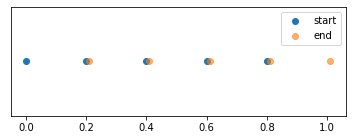

In [4]:
start_segment = np.array([mapping(vertices, i)(0) for i in range(M)])
end_segment = np.array([mapping(vertices, i)(1) for i in range(M)])

plt.figure(figsize=(6,2))
plt.scatter(start_segment, np.zeros_like(start_segment), label='start')
plt.scatter(end_segment + 1.e-2, np.zeros_like(end_segment), label='end', alpha=0.6)
plt.legend()
plt.yticks([],[])
plt.show()

### Basis functions on $\hat{T}$

We are going to use Lagrange basis functions on $\hat{T}$, therefore we define a function to compute the basis:

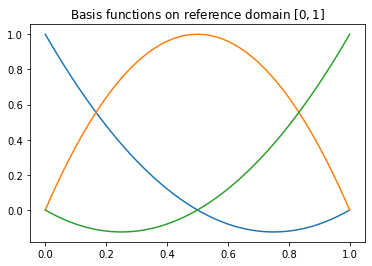

In [5]:
# we are going to use lagrange basis as a function basis on the reference sub-domain
def lagrange_basis(q, i):
    return lambda x: np.prod([(x-q[j]) / (q[i]-q[j]) for j in range(len(q)) if i != j], axis=0)

def lagrange_basis_derivative(q,i):
    t = sym.var('t')
    return sym.lambdify(t, lagrange_basis(q,i)(t).diff(t))

[plt.plot(x, lagrange_basis(reference_vertices, i)(x)) for i in range(degree+1)]
plt.title('Basis functions on reference domain $[0,1]$')
plt.show()

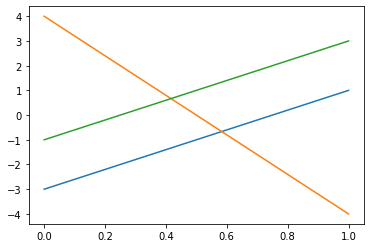

In [6]:
Vp = np.array([lagrange_basis_derivative(reference_vertices, i)(x) for i in range(degree+1)]).T
plt.plot(x,Vp);

### Integration by quadrature formula

The following is an interpolatory quadrature formula on $\widehat{T} = [0,1]$. This (the reference domain) is the **only** place where we're going to integrate.

In [7]:
q,w = np.polynomial.legendre.leggauss(n_quadrature_points)
q = (q+1)/2
w = w/2

# integrate f on [0,1]
def integrate(f):
    return np.dot(w, f(q))

def func1(x):
    return x

integrate(func1)

0.5

### Missing derivatives

Since as we mentioned in the paragraph [Renumbering and other differential amenities](#Renumbering-and-other-differential-amenities) the following equality holds
$$\nabla v_i \circ F_k = \hat{\nabla} \hat{V_\alpha} \mathbb{F}_k^{-T}$$

we would like to compute $\hat{\nabla} \hat{V_\alpha}$, which could then be used in place of $\nabla v_i \circ F_k$ in our integrations. 

In 1D the quantity $\hat{\nabla} \hat{V_\alpha}$ is implemented in the function `lagrange_basis_derivative`.

Note that $\mathbb{F}_k^{-T} = (\mathbb{F}_k^T)^{-1} = \left(\left(\frac{\partial}{\partial \hat{x}} F_k\right)^T\right)^{-1}$, which in 1D is just the inverse of the derivative of the mapping (i.e. 1/`mapping_J`).

### Continuity of basis functions

We fixed the number of basis functions for each element. However we would like to have some kind of continuity on those functions at the boundary of each element. If we have three Lagrange functions on an interval, with equispaced vertices we are going to have only one function which is not zero for each node. 

This means that 2/3 of the functions are not "problematic" (we can set them to zero for the rest of the elements, this preserves continuity). However that one function whose non-zero node is at boundary must "link" with one of the basis functions of the next elements (the first one, since it is the only basis function whose non-zero node is the first point belonging to the next element). This is why we are going to construct the matrix $P$ as explained below.

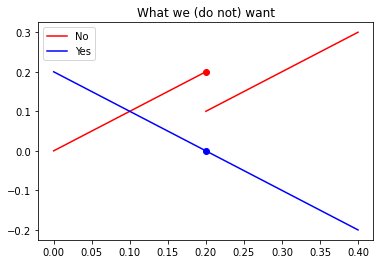

In [8]:
plt.plot(np.linspace(0,0.2,3), np.linspace(0,0.2,3), 'r')
plt.plot(np.linspace(0.2,0.4,3), np.linspace(0.2,0.4,3)-0.1, 'r', label='No')
plt.scatter([0.2], [0.2], color='r')

plt.plot(np.linspace(0,0.2,3), 0.2-np.linspace(0,0.2,3), 'b')
plt.plot(np.linspace(0.2,0.4,3), 0.2-np.linspace(0.2,0.4,3), 'b', label='Yes')
plt.scatter([0.2], [0], color='b')

plt.title('What we (do not) want')
plt.legend();

We want basis functions which are **locally** polynomials (in the elements) that are globally continous. We want polynomials because we know how to integrate them.

In [9]:
P = np.zeros((M,degree+1), dtype=int)
for k in range(M):
    start=k*degree
    P[k] = np.array(range(start,start+degree+1))
P

array([[ 0,  1,  2],
       [ 2,  3,  4],
       [ 4,  5,  6],
       [ 6,  7,  8],
       [ 8,  9, 10]])

As you can see the first basis function of the second element is the last basis function of the first element.

We now define a matrix operator which contains our basis functions in each segment.

(5, 51, 11)
On element 2
	Basis function 0 is turned-off
	Basis function 1 is turned-off
	Basis function 2 is turned-off
	Basis function 3 is turned-off
	Basis function 7 is turned-off
	Basis function 8 is turned-off
	Basis function 9 is turned-off
	Basis function 10 is turned-off


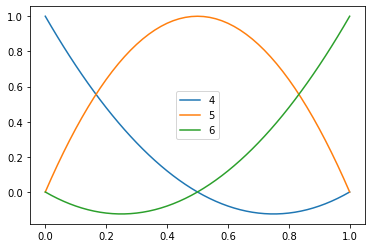

In [10]:
# B is such that B[k][x][i] is the i-th basis evaluated at x in the k-th element
# we have N basis functions on Omega
B = np.zeros((M, len(x), N))
print(B.shape)

# Remark: x is a vector of points on That
# Remark2: reference_vertices are the support points chosen on That

for k in range(M):
    # locally on each element we're going to have only degree+1 non-zero basis, the other are turned off
    # by continuity, i.e. they're set to zero in such a way that we prevent discontinuities
    B[k,:,P[k]] = np.array([lagrange_basis(reference_vertices, i)(x) for i in range(degree+1)])
    
element_idx = 2
print('On element {}'.format(element_idx))
for basis_idx in range(B.shape[2]):
    if not np.any(B[element_idx,:,basis_idx]):
        print('\tBasis function {} is turned-off'.format(basis_idx))
    else:
        plt.plot(x,B[element_idx,:,basis_idx], label=basis_idx)
plt.legend()
plt.show()

### Going back to elements

We now map our discretization `x` from $\hat{T}$ on the elements $T_k$:

In [11]:
# Remark: vertices is the triangulation of Omega

X = np.array([mapping(vertices, k)(x) for k in range(M)])
X.shape

(5, 51)

(255,)


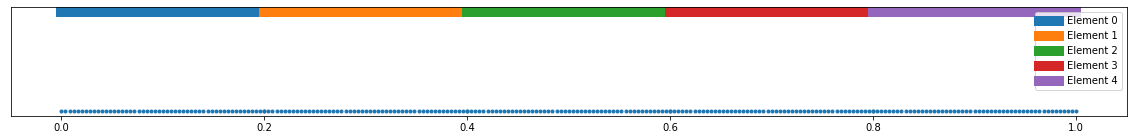

In [12]:
X2 = X.flatten()
print(X2.shape)

plt.figure(figsize=(20,2))
plt.scatter(X2, np.zeros_like(X2), marker='.')

for i in range(M):
    plt.plot([vertices[i], vertices[i+1]], [0.1, 0.1], label='Element {}'.format(i), linewidth=10)

plt.yticks([], [])
plt.legend()
plt.show()

We can use `X2` to visualize our basis functions on $\Omega$. Note that even though we computed the basis functions using `x` (discretization of $\hat{T}$) we are visualizing those basis functions on $\Omega$ with the discretization $X2 != x$.

(255, 11)


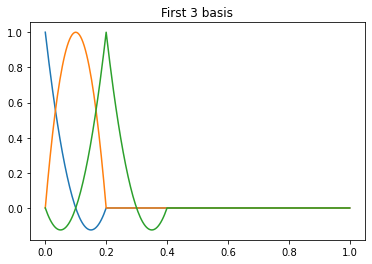

In [13]:
B2 = B.reshape((len(X2), -1))
print(B2.shape)

plt.plot(X2, B2[:,:3])
plt.title('First 3 basis');

### Break: Interpolation using $B$

Note that we can in principle use `B2` to interpolate a function on $\Omega$ (we do not have to invert any matrix since we're using (locally) the Lagrange basis). The interpolant is going to be a piece-wise polynomial of degree 2, which is different than a polynomial of degree 2. We highlight this difference in the following plot.

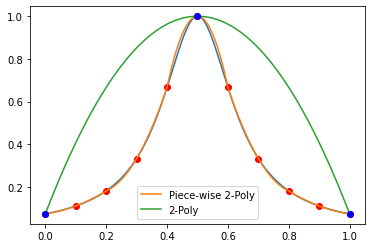

In [14]:
# we extract N support points on Omega to compute the functon
support_points = np.linspace(a,b,N)

def runge(x):
    return 1/(1+50*(x-.5)**2)

lagrange_3_support_points = np.linspace(a,b,3)
B3 = np.zeros((len(X2), 3))
for i in range(3):
    B3[:,i] = lagrange_basis(lagrange_3_support_points, i)(X2)

plt.plot(X2, runge(X2))
plt.plot(support_points, runge(support_points), 'ro')
# note that interpolation with Lagrange does not require inverting a matrix
plt.plot(X2, B2.dot(runge(support_points)), label='Piece-wise 2-Poly')
# interpolation with a 2-poly
plt.plot(X2, B3.dot(runge(lagrange_3_support_points)), label='2-Poly')
plt.plot(lagrange_3_support_points, runge(lagrange_3_support_points), 'bo')
plt.legend();

## Computing integrals

We now use the quantities we computed to complete the computation of $A_{ij}$ and $f_i$. There are two ways in which the integration can be carried out, and one of them is practically wrong. We present this really bad way beforehand, and then procede with the right solution.

### Bad way

First of all we map the quadrature points we obtained in [Integration by quadrature formula](#Integration-by-quadrature-formula) from $\hat{T}$ to the elements $T_k$. This is equivalent to computing $F_k(\hat{x})$ on each element:

(5, 5)


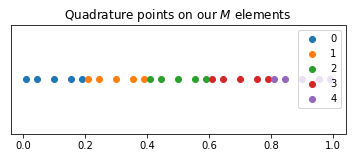

In [15]:
# for each element, these are the Gauss quadrature points which we are going to use
# in order to integrate
Q = np.array([mapping(vertices,element_idx)(q) for element_idx in range(M)])
print(Q.shape)

plt.figure(figsize=(6,2))
for i in range(Q.shape[0]):
    plt.scatter(Q[i], np.zeros_like(Q[i]), label=i)
plt.legend()
plt.yticks([],[])
plt.title('Quadrature points on our $M$ elements')
plt.show()

Then we do the same for the Jacobian of the transformation and the weights.

In [16]:
# maps the weights x Jacobian of the transformation
JxW = np.array([mapping_J(vertices,element_idx)*w for element_idx in range(M)])
JxW.shape

(5, 5)

Note that we're going to compute the Lagrange basis on `q`, which is a set of quadrature points on $\hat{T}$. Therefore we also need the "correction" given by the jacobian $J_k = \frac{\partial F_k}{\partial \hat{x}}$ of the tranformation from which we obtain $T_k$ given $\hat{T}$ (see [The mapping trick](#The-mapping-trick) for the details).

In [43]:
Bq = np.zeros((M, n_quadrature_points, N))
Vq = np.array([lagrange_basis(reference_vertices, i)(q) for i in range(degree+1)]).T

# we can re-use the same basis since each element has the same three basis functions
for k in range(M):
    Bq[k,:,P[k]] = Vq.T
    
Xq = Q.flatten()
Bq = Bq.reshape((len(Xq),-1))
JxWq = JxW.flatten()
print(Xq.shape, Bq.shape, JxWq.shape)

(25,) (25, 11) (25,)


We compute the *mass matrix* $M_{ij} = \int_\Omega v_i v_j$. We integrate over the quadrature points, so we are summing over $q$ the values $v_i(x_q) v_j(x_q)$ multiplied by $w_q$ (weight) and $J_q$. The result is a matrix.

Note that the shape of the result is $N \times N$, where $N$ is the number of basis functions which we considered on $\Omega$.

In [18]:
mass_matrix = np.einsum('qi,qj,q', Bq,Bq,JxWq)
mass_matrix.shape

(11, 11)

We now compute $f_i = \langle f|v_i \rangle = \int_{\Omega} f v_i$, being $f$ the Runge function:

In [19]:
mass_rhs = np.einsum('qi,q,q', Bq, runge(Xq), JxWq)
mass_rhs.shape

(11,)

And then we solve the problem $M_{ij} u = f_i, i = 1,\dots,N$ to find the L2 projection of $f$.

In [20]:
u_projection = np.linalg.solve(mass_matrix, mass_rhs)

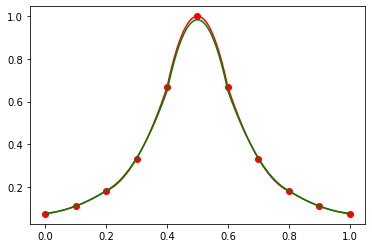

In [21]:
plt.plot(support_points, runge(support_points), 'ro')
plt.plot(X2, B2.dot(runge(support_points)), 'r')
plt.plot(X2, B2.dot(u_projection), 'g');

In [22]:
Bq.shape

(25, 11)

### Right way: integration

Note that the shape of `Bq` becomes huge for more interesting problems. Since it is a global matrix, it makes more sense to compute the integral piece by piece instead of computing global quantities. It is equivalent in terms of computational complexity, but it is not the same from a memory perspective.

We are going to exploit the fact that `Vq`, which is definied above as

In [23]:
Vq = np.array([lagrange_basis(reference_vertices, i)(q) for i in range(degree+1)])

Is the same for all the elements. Note that we divide each Lagrange basis by the inverse of the Jacobian since the formula for $A_{ij}$ is
$$ \sum_k \int_{\hat{T}} P_{ki\alpha} \left(v_\alpha'(\mathbb{F}_k^T)^{-1}\right)(\hat{x}) P_{kj\beta} \left(v_\beta'(\mathbb{F}_k^T)^{-1}\right)(\hat{x}) J_k d\hat{x}$$

As you can see the inverse of the Jacobian appears twice.

In [45]:
Bprimeq = np.zeros((M, n_quadrature_points, N))
Vprimeq = np.array([lagrange_basis_derivative(reference_vertices, i)(q) for i in range(degree+1)]).T
print(Vprimeq.shape)

for k in range(M):
    Bprimeq[k,:,P[k]] = Vprimeq.T / mapping_J(vertices, k)
    
Bprimeq = Bprimeq.reshape((len(Xq),-1))
print(Bprimeq.shape)

(5, 3)
(25, 11)


We now compute the stiffness matrix $A_{ij} = \int_\Omega v_i' v_j'$

Q: Why is the stiffness matrix not well conditioned? 

A: Because in this case we're not looking for functions in $H^1_0$, the boundary condition changes. We are now requiring that the derivative (and not the actual function) vanishes on the boundary. This is true for an infinite number of functions (e.g. constants), therefore the problem is not well conditioned.

In [46]:
stiffness_matrix = np.einsum('qi,qj,q', Bprimeq, Bprimeq, JxWq)
# condition number should be terrible
np.linalg.cond(stiffness_matrix)

3.4969317210165816e+16

In order to fix this problem we fix the matrix. We set to zero the first and last rows, and change the values of $[0,0], [-1,-1]$. Note that we're imposing a different boundary condition.

In [47]:
stiffness_matrix[0,:] = stiffness_matrix[-1,:] = 0
stiffness_matrix[0,0] = stiffness_matrix[-1,-1] = 1
np.linalg.cond(stiffness_matrix)

129.9069289964899

In [48]:
def rhs_function(x):
    return 0*x+1

rhs = np.einsum('qi,q,q', Bq, rhs_function(Xq), JxWq)
rhs[0] = rhs[-1] = 0

The solution of the problem is given by $\sum_j u_j v_j$ where ${v_j}_{j=0}^{N-1}$ is the set of basis we determined on $\Omega$, and $u_j = A_{ij}^{-1} \tilde{f}$ where $\tilde{f} = \begin{bmatrix} f_1, \dots f_{N-1}\end{bmatrix}^t$:

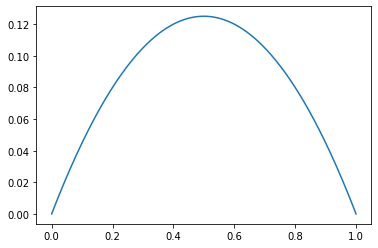

In [52]:
u = np.linalg.solve(stiffness_matrix, rhs)
plt.plot(X2, B2.dot(u));

An important feature of Finite Element method is the fact that if we integrate exactly $\tilde{f}$ we get the exact solution on the control points.